In [15]:
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , LabelEncoder
from lightgbm import LGBMClassifier
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score, accuracy_score, balanced_accuracy_score
from collections import namedtuple
import pandas as pd
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
import numpy as np
from ipynb.fs.full.evaluation import *
from ipynb.fs.full.Data_Processing import *
from sklearn.model_selection import KFold
import time

### Baseline classification performance on EEG Dataset

Get with 5 fold cross-validation and performance on the test set
- Load the data of each user for all tests 
- Get performance per user - attention, interest, effort
- Get performance per user 

### 1) Load the data

In [3]:
def average(lst): 
    return sum(lst) / len(lst) 

In [32]:
def choose_base_model(model_type, objective):
    # choose model
    if model_type == 'clf':
        model = LGBMClassifier(objective=objective,num_leaves=31, learning_rate=0.1, random_state=5)
        return model
    else: 
        model = LGBMRegressor(num_leaves=31, learning_rate=0.1, random_state=5),
        return model

def choose_obj(num_classes):
    if num_classes == 2:
        objective = 'binary'
        return objective
    else: 
        objective = 'multiclass' 
        return objective

In [30]:
def kfold_predict(X,y, model_type):
    """
    Method for running 5 fold cross validation based on a given array of tests
    """
    kf= KFold(n_splits = 5, shuffle = True, random_state =  1)
    
    if model_type == 'clf':
        results = {"Accuracy":[], "Precision":[], "Recall":[], "F1 Score Macro":[],
              "F1 Score Micro":[],"Balanced Accuracy":[]}
    else:
        results = {'RMSE':[], 'R2':[]}
        
    total_predictions = []
    total_true = []
    num_classes = 0
    for train_index, test_index in kf.split(X):

        #Train/test split
        X_train, X_test = np.concatenate(X[train_index]), np.concatenate(X[test_index])
        y_train, y_test = np.concatenate(y[train_index]).astype('int'), np.concatenate(y[test_index]).astype('int')
        total_true.append(y_test)
        size = len(X_train) + len(X_test)
        
        if len(set(y_train)) > num_classes:
            num_classes = len(set(y_train))
        objective = choose_obj(num_classes)           
        model = choose_base_model(model, model_type, objective).fit(X_train,y_train)
        y_pred = model.predict(X_test)
        total_predictions.append(y_pred)
        r = get_results(y_test, y_pred, model_type) # get dictionary of all results
        
        for key in r: # loop through dictionary to add to all the scores to the results dictionary
            results[key].append(r[key])

    for key in results: # average out the results 
        results[key] = average(results[key])

    return results, np.concatenate(total_predictions), np.concatenate(total_true) , num_classes , size

In [19]:
def collate_results(r, user, label, num_classes, duration, order, size):
    """
    Method for collating the results in a single tuple
    :r: results 
    :user: current user
    :num_classes: number of targets 
    """
    Results = namedtuple("Results","user label num_classes duration order size accuracy bal_acc precision recall f1_score_macro f1_score_micro")
    collated_results = Results(user, label, num_classes, duration, order, size, r['Accuracy'], r['Balanced Accuracy'], r['Precision'], r['Recall'], 
                                  r['F1 Score Macro'], r['F1 Score Micro'])
    return collated_results

In [20]:
def get_results_per_user(all_users, users, results, labels , bandpass, order, model_type, lowcut=0.1, highcut=40.0, fs=500.0):
    """
    Method for getting results per user by applying 5 fold cross validation.
    """
    for user in users:
        print("Running User {0}".format(user))

        for label in labels:
            time_start = time.time()
            test_list = all_users[user] # list of all the tests
            if bandpass == True:
                X = np.array([np.array(filter_df(test.iloc[:,:8], lowcut, highcut, fs, order)) for test in test_list]) # filtered array of all the inputs for each test
            else:
                X = np.array([np.array(test.iloc[:,:8]) for test in test_list]) # array of all the inputs for each test
            y = np.array([np.array(test[label]) for test in test_list]) # array of given labels for each test           

            # get results
            r, y_pred, y_true, num_classes, size = kfold_predict(X,y, model_type)
            duration = time.time() - time_start
            results.append(collate_results(r, user, label, num_classes, duration, order, size))

            if model_type == 'clf':
                # plot confusion matrix
                cm = confusion_matrix(y_true, y_pred)
                saved_file = "results/baseline/confusion matrices/k_fold_performance/LGBM_User_{0}_{1}_{2}.png".format(user,label,order)
                plot_confusion_matrix(cm, set(y_true), normalize=True , file = saved_file)

In [27]:
def get_results_cross_users(labels, all_users_agg, results, bandpass, order, lowcut=0.1, highcut=40.0, fs=500.0):
    """
    Method for getting results cross-user using 5-Fold cross-validation
    """
    # get the results cross-user
    for label in labels: #put the inputs and labels in an array for K-fold
        time_start = time.time()
        if bandpass == True: # filter the channels using bandpass filtering
            X = np.array([np.array(filter_df(all_users_agg[key].iloc[:, :8], lowcut, highcut, fs, order )) for key in all_users_agg]) #array of aggregated inputs per user
        else:
            X = np.array([np.array(all_users_agg[key].iloc[:, :8] ) for key in all_users_agg])
        y = np.array([np.array(all_users_agg[key][label]) for key in all_users_agg]) # array of aggregated labels per user        

        # get results 
        r, y_pred, y_true, num_classes , size = kfold_predict(X,y)
        duration = time.time() - time_start
        results.append(collate_results(r, user, label, num_classes, duration, order, size))

        # plot confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        saved_file = "results/baseline/confusion matrices/k_fold_performance/LGBM_User_{0}_{1}_{2}.png".format('all',label,order)
        plot_confusion_matrix(cm, set(y_true), normalize=True , file = saved_file)

In [28]:
def get_all_results():
    """
    Method for getting all results per user and across users by applying 5 fold cross validation.
    """
    # Load all the data
    per_user_path = "/cs/home/ybk1/Dissertation/data/all_tests_EEG_no_agg.pickle"
    all_user_path = "/cs/home/ybk1/Dissertation/data/all_tests_EEG.pickle"
    all_users_no_agg = load_file(per_user_path) # dictionary of all users , where tests are split out by user without aggregation for per user analysis
    all_users_agg = load_file(all_user_path) # dictionary of all users, where tests are aggregated by user for cross-user analysis
    
    users = all_users_no_agg.keys()
    results = []
    labels = ['attention','interest','effort']
    
    time_start = time.time()
    for order in [2,3,4,5,6]:
        # get the results per user
#         get_results_per_user(all_users_no_agg, users, results, labels, True, order, lowcut=0.1, highcut=40.0, fs=500.0)

         # get the results cross user
        get_results_cross_users(labels, all_users_agg, results , True, order, lowcut=0.1, highcut=40.0, fs=500.0)

    results  = pd.DataFrame(results).to_csv("results/baseline/tabulated/k fold/LGBM_5_fold_CV_performance_all_user_bandpass.csv", index=False)
    print("Time elapsed! {0}".format(time.time() - time_start))
    return results

TRAIN: [ 0  1  4  5  7  8  9 10 11 12 14 15 16 17] TEST: [ 2  3  6 13]
y_pred: {1, 2, 3, 4, 5}
y_true: {1, 2, 3, 4, 5}
TRAIN: [ 0  1  2  3  5  6  8  9 10 11 12 13 16 17] TEST: [ 4  7 14 15]
y_pred: {1, 2, 3, 4, 5}
y_true: {1, 2, 3, 4, 5}
TRAIN: [ 2  3  4  5  6  7  8  9 11 12 13 14 15 16] TEST: [ 0  1 10 17]
y_pred: {1, 2, 3, 4, 5}
y_true: {1, 2, 3, 4, 5}
TRAIN: [ 0  1  2  3  4  5  6  7 10 11 12 13 14 15 17] TEST: [ 8  9 16]
y_pred: {1, 2, 3, 4, 5}
y_true: {1, 2, 3, 4, 5}
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 13 14 15 16 17] TEST: [ 5 11 12]
y_pred: {1, 2, 3, 4, 5}
y_true: {1, 2, 3, 4, 5}
[0.212120956707658, 0.28405406651266896, 0.16761371542699047, 0.14551439520487375, 0.20066303565098553]
Normalized confusion matrix
[[0.01717509 0.29423515 0.3309242  0.27456058 0.08310497]
 [0.02071792 0.2725368  0.35250747 0.2811672  0.0730706 ]
 [0.03831115 0.33992303 0.3077001  0.24530761 0.06875811]
 [0.05859796 0.35864715 0.29641584 0.20486816 0.08147089]
 [0.04368595 0.42187356 0.31792939 0.1349

/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TRAIN: [ 0  1  2  3  5  6  8  9 10 11 12 13 16 17] TEST: [ 4  7 14 15]
y_pred: {1, 2, 3, 4, 5}
y_true: {1, 2, 3, 4, 5}
TRAIN: [ 2  3  4  5  6  7  8  9 11 12 13 14 15 16] TEST: [ 0  1 10 17]
y_pred: {1, 2, 3, 4, 5}
y_true: {1, 2, 3, 4, 5}
TRAIN: [ 0  1  2  3  4  5  6  7 10 11 12 13 14 15 17] TEST: [ 8  9 16]
y_pred: {1, 2, 3, 4, 5}
y_true: {1, 2, 3, 4, 5}
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 13 14 15 16 17] TEST: [ 5 11 12]
y_pred: {1, 2, 3, 4, 5}
y_true: {1, 2, 3, 4, 5}
[0.25849256452831887, 0.39708360436588624, 0.3595953146870319, 0.312641249877174, 0.3064187825916356]
Normalized confusion matrix
[[0.04714985 0.83077486 0.0814364  0.02871987 0.01191902]
 [0.06569119 0.7829336  0.1018017  0.03758871 0.01198481]
 [0.05123149 0.8193862  0.10273188 0.02341387 0.00323655]
 [0.05854914 0.84225996 0.07242298 0.01293134 0.01383657]
 [0.06989995 0.79621295 0.08655724 0.00796461 0.03936526]]
TRAIN: [ 0  1  4  5  7  8  9 10 11 12 14 15 16 17] TEST: [ 2  3  6 13]
y_pred: {1, 2, 3, 4, 5}
y_true: 

/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.2451120869611636, 0.2931675894578154, 0.1099575178645974, 0.15787560184730273, 0.20270520329154618]
Normalized confusion matrix
[[0.00901918 0.23158772 0.35010189 0.33490931 0.07438191]
 [0.01666218 0.2699599  0.3523286  0.28635642 0.0746929 ]
 [0.06047561 0.30024541 0.34838313 0.21174756 0.0791483 ]
 [0.04335641 0.4012212  0.30677562 0.19667385 0.05197291]
 [0.02081216 0.55225812 0.28954618 0.10466145 0.0327221 ]]
TRAIN: [ 0  1  4  5  7  8  9 10 11 12 14 15 16 17] TEST: [ 2  3  6 13]
y_pred: {1, 2, 3, 4, 5}
y_true: {1, 2, 3, 4, 5}
TRAIN: [ 0  1  2  3  5  6  8  9 10 11 12 13 16 17] TEST: [ 4  7 14 15]
y_pred: {1, 2, 3, 4, 5}
y_true: {1, 2, 3, 4, 5}
TRAIN: [ 2  3  4  5  6  7  8  9 11 12 13 14 15 16] TEST: [ 0  1 10 17]
y_pred: {1, 2, 3, 4, 5}
y_true: {1, 2, 3, 4, 5}
TRAIN: [ 0  1  2  3  4  5  6  7 10 11 12 13 14 15 17] TEST: [ 8  9 16]
y_pred: {1, 2, 3, 4, 5}
y_true: {1, 2, 3, 4, 5}
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 13 14 15 16 17] TEST: [ 5 11 12]
y_pred: {1, 2, 3, 4, 5}
y_true:

/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TRAIN: [ 0  1  2  3  5  6  8  9 10 11 12 13 16 17] TEST: [ 4  7 14 15]
y_pred: {1, 2, 3, 4, 5}
y_true: {1, 2, 3, 4, 5}
TRAIN: [ 2  3  4  5  6  7  8  9 11 12 13 14 15 16] TEST: [ 0  1 10 17]
y_pred: {1, 2, 3, 4}
y_true: {1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TRAIN: [ 0  1  2  3  4  5  6  7 10 11 12 13 14 15 17] TEST: [ 8  9 16]
y_pred: {1, 2, 3, 4}
y_true: {1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TRAIN: [ 0  1  2  3  4  6  7  8  9 10 13 14 15 16 17] TEST: [ 5 11 12]
y_pred: {1, 2, 3}
y_true: {1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.2624807194693324, 0.3308321510338505, 0.3620050913079423, 0.3335953620909895, 0.35413104206285684]
Normalized confusion matrix
[[0.03597728 0.87598206 0.05457894 0.03180459 0.00165713]
 [0.07546761 0.803203   0.04969713 0.04953789 0.02209437]
 [0.07158613 0.79379189 0.05507015 0.04584373 0.03370811]
 [0.03062308 0.89014614 0.03139252 0.03797933 0.00985892]
 [0.01712612 0.94421463 0.0289186  0.00974065 0.        ]]
TRAIN: [ 0  1  4  5  7  8  9 10 11 12 14 15 16 17] TEST: [ 2  3  6 13]
y_pred: {2, 3, 4, 5}
y_true: {1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TRAIN: [ 0  1  2  3  5  6  8  9 10 11 12 13 16 17] TEST: [ 4  7 14 15]
y_pred: {1, 2, 3, 4, 5}
y_true: {1, 2, 3, 4, 5}
TRAIN: [ 2  3  4  5  6  7  8  9 11 12 13 14 15 16] TEST: [ 0  1 10 17]
y_pred: {1, 2, 3, 4, 5}
y_true: {1, 2, 3, 4, 5}
TRAIN: [ 0  1  2  3  4  5  6  7 10 11 12 13 14 15 17] TEST: [ 8  9 16]
y_pred: {1, 2, 3, 4, 5}
y_true: {1, 2, 3, 4, 5}
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 13 14 15 16 17] TEST: [ 5 11 12]
y_pred: {1, 2, 3, 4, 5}
y_true: {1, 2, 3, 4, 5}
[0.2553669411596133, 0.33247798020566033, 0.13469538098863051, 0.17970423503979563, 0.17147742802808202]
Normalized confusion matrix
[[0.0326387  0.17041588 0.36970117 0.17043093 0.25681332]
 [0.01570403 0.28348021 0.36993121 0.20183943 0.12904511]
 [0.00301035 0.38313352 0.39433831 0.17720265 0.04231517]
 [0.00740438 0.42286233 0.3247471  0.1828018  0.06218439]
 [0.00178    0.56912302 0.29659137 0.09672735 0.03577825]]
TRAIN: [ 0  1  4  5  7  8  9 10 11 12 14 15 16 17] TEST: [ 2  3  6 13]
y_pred: {1, 2, 3, 4, 5}
y_tru

/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TRAIN: [ 0  1  2  3  5  6  8  9 10 11 12 13 16 17] TEST: [ 4  7 14 15]
y_pred: {1, 2, 3, 4, 5}
y_true: {1, 2, 3, 4, 5}
TRAIN: [ 2  3  4  5  6  7  8  9 11 12 13 14 15 16] TEST: [ 0  1 10 17]
y_pred: {1, 2, 3, 4}
y_true: {1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TRAIN: [ 0  1  2  3  4  5  6  7 10 11 12 13 14 15 17] TEST: [ 8  9 16]
y_pred: {1, 2, 3, 4}
y_true: {1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TRAIN: [ 0  1  2  3  4  6  7  8  9 10 13 14 15 16 17] TEST: [ 5 11 12]
y_pred: {1, 2, 3, 5}
y_true: {1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.2658409401875093, 0.40615956689424865, 0.3756484869320368, 0.3393190527660411, 0.2714723003145741]
Normalized confusion matrix
[[0.00458324 0.87759626 0.0654548  0.01227919 0.04008651]
 [0.02084141 0.84576687 0.0750276  0.02003579 0.03832833]
 [0.02818394 0.88510327 0.06346259 0.02325019 0.        ]
 [0.01036211 0.92329852 0.04039947 0.01354636 0.01239354]
 [0.00861546 0.94981853 0.03704317 0.00452284 0.        ]]
Time elapsed! 2201.9170989990234


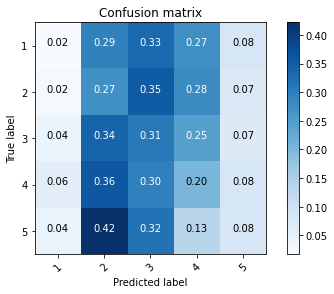

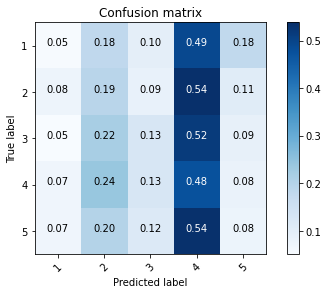

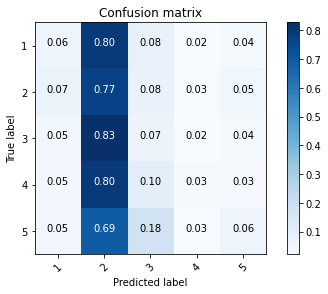

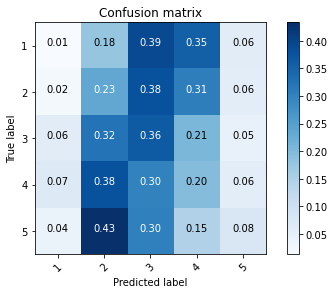

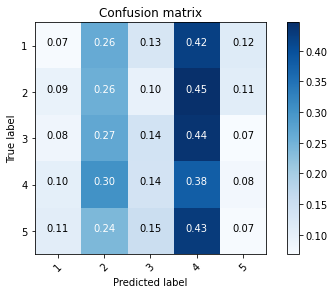

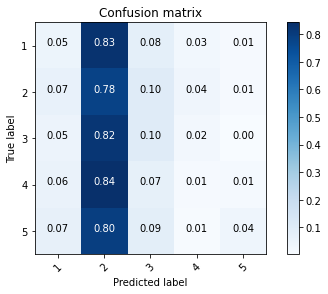

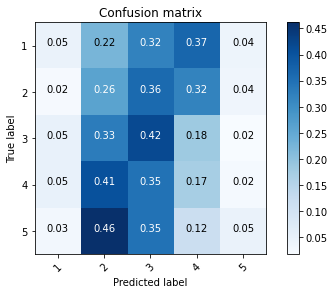

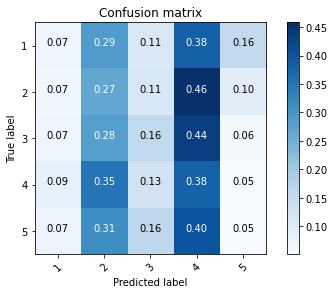

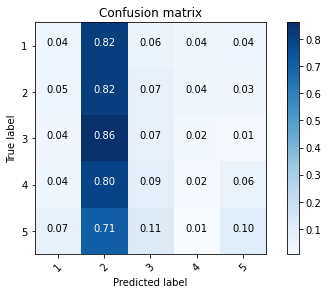

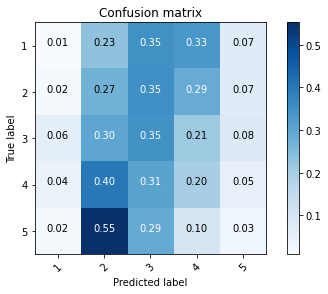

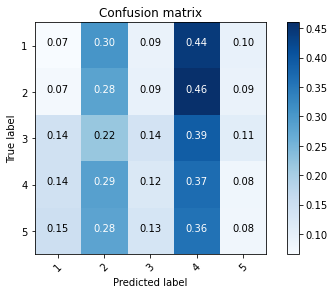

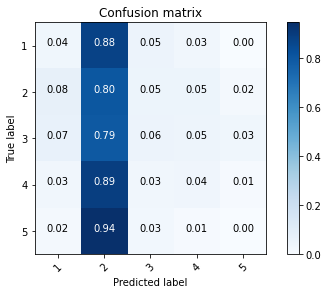

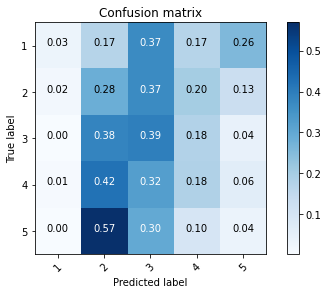

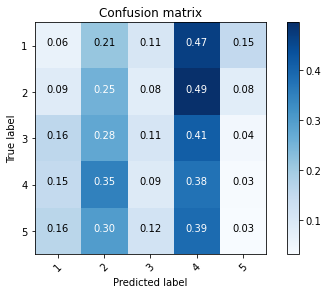

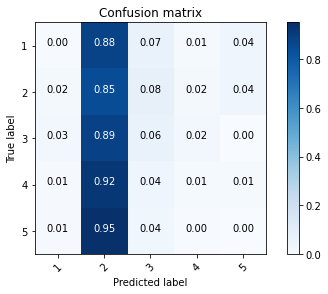

In [29]:
r = get_all_results()